# Diagnostyka szeregów czasowych

Celem analizy jest ocena jakości szeregów czasowych popytu na poziomie `(country, sku, dc_id)`
przed walidacją modeli i budową prognoz. Diagnostyka koncentruje się na długości historii,
kompletności osi czasu oraz przerwach w obserwacjach.

Analiza bazuje na zbiorze `master_model_ready`.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

pd.set_option("display.max_rows", 25)
pd.set_option("display.max_columns", None)

DATA_DIR = Path("data")
df = pd.read_parquet(DATA_DIR / "master_model_ready.parquet")


## Zakres danych i definicja serii

Jedna seria czasowa jest definiowana jako kombinacja:
`(country, sku, dc_id)`.

W pierwszym kroku usuwane są obserwacje bez poprawnej daty oraz ograniczamy analizę
do rzeczywiście występujących kombinacji klucza serii.


In [2]:
series_key = ["country", "sku", "dc_id"]

df_ts = df.copy()
df_ts["date"] = pd.to_datetime(df_ts["date"], errors="coerce")
df_ts = df_ts[df_ts["date"].notna()].copy()

n_series = df_ts[series_key].drop_duplicates().shape[0]
n_series


88

## Długość historii serii

Dla każdej serii wyznaczana jest liczba tygodni obserwacji (`n_weeks`).
Metryka stanowi podstawowy wskaźnik przydatności serii do walidacji i modelowania.


In [3]:
series_length = (
    df_ts
    .groupby(series_key, observed=True)["date"]
    .nunique()
    .reset_index(name="n_weeks")
)

series_length["n_weeks"].describe()


count     88.000000
mean     214.977273
std      115.278571
min        1.000000
25%      160.000000
50%      201.000000
75%      340.250000
max      357.000000
Name: n_weeks, dtype: float64

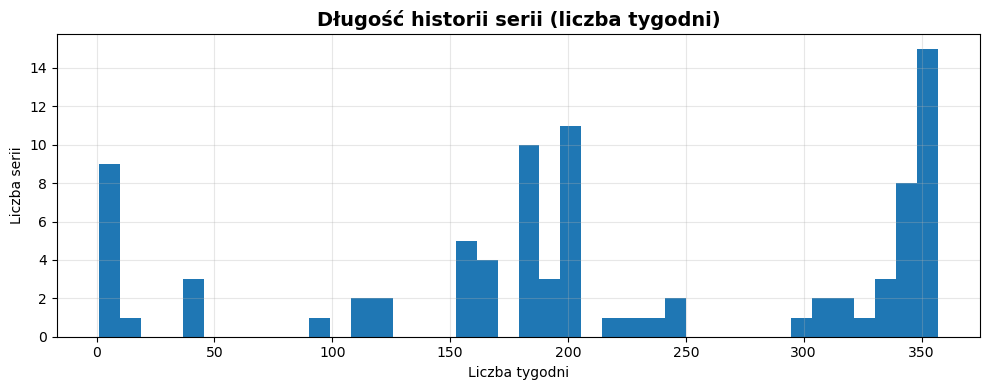

In [4]:
plt.figure(figsize=(10, 4))
plt.hist(series_length["n_weeks"], bins=40)
plt.title("Długość historii serii (liczba tygodni)", fontsize=14, fontweight="bold")
plt.xlabel("Liczba tygodni")
plt.ylabel("Liczba serii")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


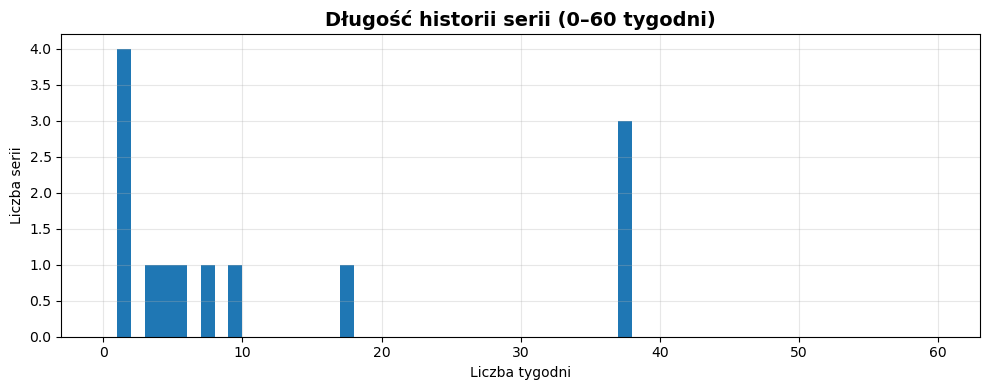

In [5]:
plt.figure(figsize=(10, 4))
plt.hist(series_length["n_weeks"], bins=60, range=(0, 60))
plt.title("Długość historii serii (0–60 tygodni)", fontsize=14, fontweight="bold")
plt.xlabel("Liczba tygodni")
plt.ylabel("Liczba serii")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Zakres dat i braki tygodni

Dla każdej serii wyznaczany jest zakres obserwacji (`min_date`, `max_date`) oraz liczba brakujących tygodni
pomiędzy tymi datami przy częstotliwości tygodniowej (poniedziałki ISO).


In [6]:
series_span = (
    df_ts
    .groupby(series_key, observed=True)
    .agg(
        min_date=("date", "min"),
        max_date=("date", "max"),
        n_weeks=("date", "nunique"),
    )
    .reset_index()
)

pd.to_datetime(series_span["min_date"]).describe(), pd.to_datetime(series_span["max_date"]).describe()


(count                     88
 mean     2020-09-17 12:00:00
 min      2018-12-31 00:00:00
 25%      2018-12-31 00:00:00
 50%      2019-07-15 00:00:00
 75%      2022-02-17 12:00:00
 max      2025-02-17 00:00:00
 Name: min_date, dtype: object,
 count                               88
 mean     2025-03-13 02:27:16.363636480
 min                2022-01-03 00:00:00
 25%                2025-10-20 00:00:00
 50%                2025-11-03 00:00:00
 75%                2025-11-03 00:00:00
 max                2025-11-03 00:00:00
 Name: max_date, dtype: object)

In [7]:
def count_missing_weeks(dates: pd.Series) -> int:
    dates = pd.to_datetime(dates).dropna().sort_values()
    full_range = pd.date_range(start=dates.min(), end=dates.max(), freq="W-MON")
    return len(full_range.difference(dates))

missing_weeks = (
    df_ts
    .groupby(series_key, observed=True)["date"]
    .apply(count_missing_weeks)
    .reset_index(name="missing_weeks")
)

missing_weeks["missing_weeks"].describe()


count     88.000000
mean      19.965909
std       36.234374
min        0.000000
25%        0.000000
50%        6.500000
75%       24.250000
max      183.000000
Name: missing_weeks, dtype: float64

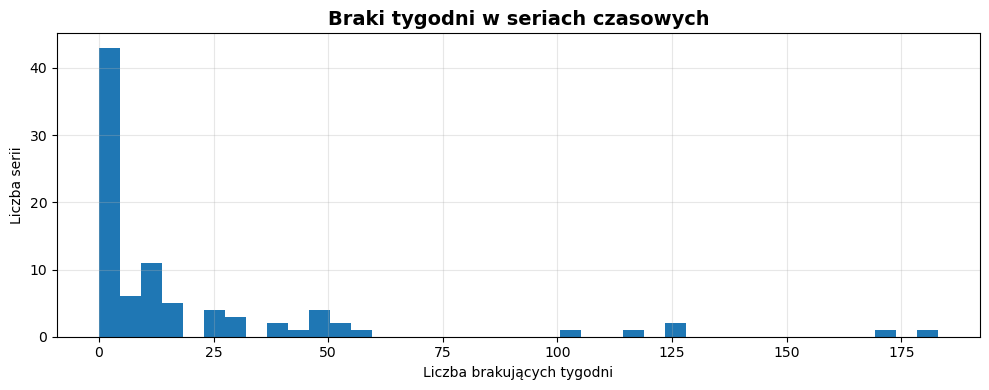

In [8]:
plt.figure(figsize=(10, 4))
plt.hist(missing_weeks["missing_weeks"], bins=40)
plt.title("Braki tygodni w seriach czasowych", fontsize=14, fontweight="bold")
plt.xlabel("Liczba brakujących tygodni")
plt.ylabel("Liczba serii")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Tabela diagnostyczna

Metryki jakości są łączone w jedną tabelę `ts_diagnostics`, która będzie wykorzystana
do selekcji serii pod walidację i modelowanie.


In [9]:
ts_diagnostics = series_span.merge(missing_weeks, on=series_key, how="left")

ts_diagnostics[["n_weeks", "missing_weeks"]].describe()


,n_weeks,missing_weeks
count,88.000000,88.000000
mean,214.977273,19.965909
std,115.278571,36.234374
min,1.000000,0.000000
25%,160.000000,0.000000
50%,201.000000,6.500000
75%,340.250000,24.250000
max,357.000000,183.000000


In [10]:
ts_diagnostics.sort_values(["n_weeks", "missing_weeks"], ascending=[True, False]).head(15)


,country,sku,dc_id,min_date,max_date,n_weeks,missing_weeks
31,Portugal,00012-619-000,503,2024-11-25,2024-11-25,1,0
50,Spain,00023-189-000,110,2022-11-21,2022-11-21,1,0
63,Spain,00119-066-001,110,2022-11-21,2022-11-21,1,0
70,Spain,04592-030-000,110,2022-11-21,2022-11-21,1,0
35,Portugal,00041-097-000,600,2022-08-15,2023-02-20,3,25
0,Germany,00004-807-019,100,2023-05-22,2025-06-09,4,104
1,Germany,00004-807-019,200,2024-09-02,2024-09-30,5,0
2,Germany,00004-807-019,300,2023-05-01,2025-10-27,7,124
3,Germany,00004-807-019,400,2022-01-31,2025-09-29,9,183
32,Portugal,00012-619-000,600,2022-03-21,2025-10-27,17,172
